<a href="https://colab.research.google.com/github/datascisteven/greenflash_llm_project/blob/main/Greenflash_Toxicity_Multi_Class_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# prompt: authenticate with hugging face
from huggingface_hub import login

login()

                                                                                                                                                
# Importing Necessary Libraries



In [3]:
!pip install -q datasets transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.5 MB/s eta 0:00:00


In [7]:
import pandas as pd
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (
    TensorDataset,
    DataLoader,
    RandomSampler,
    SequentialSampler,
    random_split,
)
from transformers import (
    BertTokenizer,
    BertModel,
    AdamW,
    get_linear_schedule_with_warmup,
)
import time
import datetime
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score
)

import re
import warnings
warnings.filterwarnings("ignore")

from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# pd.set_option('display.width', 200)
# pd.set_option('display.max_colwidth', None)

import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
dataset = pd.read_csv('/content/drive/MyDrive/Projects/Greenflash/Toxicity/jigsaw_train_revised.csv', index_col=0)
dataset.head()

,id,comment_text,toxicity,severe_toxicity,obscene,sexual_explicit,identity_attack,insult,threat,race,gender,sexual_orientation,religion,ability
0,1083994,He got his money... now he lies in wait till a...,0,0,0,0,0,0,0,0,0,0,0,0
1,650904,Mad dog will surely put the liberals in mental...,1,0,0,0,0,1,0,0,0,0,0,0
2,5902188,And Trump continues his lifelong cowardice by ...,1,0,0,0,0,1,0,0,0,0,0,0
4,5410943,Tucker and Paul are both total bad ass mofo's.,1,0,0,0,0,0,0,0,0,0,0,0
5,6290444,"Cry me a river, why don't you.\nDrinking, drug...",0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
dataset.columns.tolist()

['id',
 'comment_text',
 'toxicity',
 'severe_toxicity',
 'obscene',
 'sexual_explicit',
 'identity_attack',
 'insult',
 'threat',
 'race',
 'gender',
 'sexual_orientation',
 'religion',
 'ability']

In [ ]:
len(dataset)

1804812

In [ ]:
dataset.toxicity.value_counts()

,count
toxicity,
0,1698374
1,106438


In [30]:
non_toxic = dataset.loc[dataset.toxicity==0]
toxic = dataset.loc[dataset.toxicity==1]

non_toxic = non_toxic.sample(n=len(toxic), random_state=42)

dataset = pd.concat([non_toxic, toxic])
dataset.toxicity.value_counts()

,count
toxicity,
0,106438
1,106438


In [ ]:
# Filter rows where the values in 'mixed_column' are not strings
non_string_rows = dataset[~dataset['comment_text'].apply(lambda x: isinstance(x, str))]

print(non_string_rows)

Empty DataFrame
Columns: [id, comment_text, toxicity, severe_toxicity, obscene, sexual_explicit, identity_attack, insult, threat, race, gender, sexual_orientation, religion, ability]
Index: []


# Preparing Environment

In [28]:
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    device = torch.device("cuda")
    print("Using GPU: ", torch.cuda.current_device())
else:
    device = torch.device("cpu")

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

Using GPU:  0


# Preparing Dataset

In [31]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

def get_dataset(df, tokenizer, mode="train"):
    sentences, labels = df["comment_text"], df.iloc[:, 2:].to_numpy()
    max_length = 300
    in_T = []
    in_T_attn_masks = []
    for sentence in sentences:
        enc_sent_dict = tokenizer.encode_plus(
            sentence[:300],
            max_length=max_length,
            add_special_tokens=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            truncation=True,
            return_tensors="pt",
        )
        in_T.append(enc_sent_dict["input_ids"])
        in_T_attn_masks.append(enc_sent_dict["attention_mask"])

    in_T = torch.cat(in_T, dim=0)
    in_T_attn_masks = torch.cat(in_T_attn_masks, dim=0)
    labels = torch.tensor(labels, dtype=torch.float32)
    print("Text Input: ", in_T.shape)
    print("Text Input Attention: ", in_T_attn_masks.shape)
    print("Labels: ", labels.shape)

    dataset = TensorDataset(in_T, in_T_attn_masks, labels)

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    return train_dataset, val_dataset


train_dataset, val_dataset = get_dataset(
    dataset, tokenizer=tokenizer, mode="train"
)

batch_size = 8
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, sampler=RandomSampler(train_dataset)
)
val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size, sampler=SequentialSampler(val_dataset)
)

print("Data Ready!!")

Text Input:  torch.Size([212876, 300])
Text Input Attention:  torch.Size([212876, 300])
Labels:  torch.Size([212876, 12])
Data Ready!!


# Preparing Model

In [32]:
class MultiTaskClassifier(nn.Module):
    def __init__(self, hidden_dim, num_labels):
        super(MultiTaskClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_labels = num_labels

        self.bertmodel = BertModel.from_pretrained("bert-base-uncased")
        self.ffn1 = nn.Linear(768, hidden_dim)
        self.dp1 = nn.Dropout()
        self.ffn2 = nn.Linear(hidden_dim, num_labels)

    def forward(self, in_T, in_T_attn_masks):
        hidden_states = self.bertmodel(in_T, in_T_attn_masks)[0]  # Get the first output (hidden states)
        x = torch.mean(hidden_states, dim=1)
        x = F.relu(self.ffn1(x))
        x = self.dp1(x)
        x = torch.sigmoid(self.ffn2(x))
        return x


model = MultiTaskClassifier(100, 12).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
criterion = nn.BCELoss()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

# Training and Validation

In [ ]:
len(train_dataloader)

180482

In [ ]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))


# def find_best_thresholds(true_labels, pred_logits):
#     best_thresholds = []
#     for i in range(pred_logits.shape[1]):
#         thresholds = np.arange(0.1, 0.9, 0.05)
#         best_f1 = 0
#         best_threshold = 0.25  # Default
#         for t in thresholds:
#             pred_labels = (pred_logits[:, i] >= t).astype(int)
#             f1 = f1_score(true_labels[:, i], pred_labels, average='macro')
#             if f1 > best_f1:
#                 best_f1 = f1
#                 best_threshold = t
#         best_thresholds.append(best_threshold)
#     return best_thresholds

In [ ]:
epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

training_stats = []
total_t0 = time.time()

best_val_loss = 1e8

true_labels = torch.cat([batch[2] for batch in val_dataloader]).numpy()

for epoch in range(0, epochs):

    print(f"\n======== Epoch {epoch + 1} / {epochs} ========")
    print("Training...")

    t0 = time.time()
    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print(f" Batch {step:>5,}  of  {len(train_dataloader):>5,}. Elapsed: {elapsed}. Loss: {total_train_loss / step:.5f}")

        b_in_T = batch[0].to(device)
        b_in_T_attn_masks = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        logits = model(b_in_T, b_in_T_attn_masks)
        loss = criterion(logits, b_labels)

        total_train_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print(f"\n  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training epoch took: {training_time}")

    print("\nRunning Validation...")

    t0 = time.time()
    model.eval()

    total_eval_loss = 0
    pred_labels = np.empty((0, 12))

    for batch in val_dataloader:
        b_in_T = batch[0].to(device)
        b_in_T_attn_masks = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            logits = model(b_in_T, b_in_T_attn_masks)
            loss = criterion(logits, b_labels)

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        # Correctly populate pred_logits with the model's output
        pred_labels = np.concatenate((pred_labels, logits), axis=0)

    avg_val_loss = total_eval_loss / len(val_dataloader)
    validation_time = format_time(time.time() - t0)

    pred_labels = np.array(
        [[int(x >= 0.25) for x in pred_labels[:, i]] for i in range(12)]
    ).transpose()

    print(f"  Validation Loss: {avg_val_loss:.2f}")
    print(f"  Validation took: {validation_time}")

    for i in range(12):
        print(f"  Accuracy (Class {i}): {accuracy_score(true_labels[:, i], pred_labels[:, i]):.2f}")
        print(f"  Macro F1-score (Class {i}): {f1_score(true_labels[:, i], pred_labels[:, i], average='macro'):.2f}")
        print(f"  Weighted F1-score (Class {i}): {f1_score(true_labels[:, i], pred_labels[:, i], average='weighted'):.2f}")
        print(f"  Confusion Matrix (Class {i}): \n{confusion_matrix(true_labels[:, i], pred_labels[:, i])}")
        print(f"  Precision (Class {i}): {precision_score(true_labels[:, i], pred_labels[:, i]):.2f}")
        print(f"  Recall (Class {i}): {recall_score(true_labels[:, i], pred_labels[:, i]):.2f}")

    training_stats.append(
        {
            "epoch": epoch + 1,
            "training_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "val_accuracy": np.mean([accuracy_score(true_labels[:, i], pred_labels[:, i]) for i in range(12)]),
            "val_macro_f1": np.mean([f1_score(true_labels[:, i], pred_labels[:, i], average="macro") for i in range(12)]),
            "val_weighted_f1": np.mean([f1_score(true_labels[:, i], pred_labels[:, i], average="weighted") for i in range(12)]),
            "val_precision": np.mean([precision_score(true_labels[:, i], pred_labels[:, i]) for i in range(12)]),
            "val_recall": np.mean([recall_score(true_labels[:, i], pred_labels[:, i]) for i in range(12)]),
            "val_accuracy_class_1": accuracy_score(true_labels[:, 0], pred_labels[:, 0]),
            "val_macro_f1_class_1": f1_score(true_labels[:, 0], pred_labels[:, 0], average="macro"),
            "val_precision_class_1": precision_score(true_labels[:, 0], pred_labels[:, 0]),
            "val_recall_class_1": recall_score(true_labels[:, 0], pred_labels[:, 0]),
            "val_accuracy_class_2": accuracy_score(true_labels[:, 1], pred_labels[:, 1]),
            "val_macro_f1_class_2": f1_score(true_labels[:, 1], pred_labels[:, 1], average="macro"),
            "val_precision_class_2": precision_score(true_labels[:, 1], pred_labels[:, 1]),
            "val_recall_class_2": recall_score(true_labels[:, 1], pred_labels[:, 1]),
            "val_accuracy_class_3": accuracy_score(true_labels[:, 2], pred_labels[:, 2]),
            "val_macro_f1_class_3": f1_score(true_labels[:, 2], pred_labels[:, 2], average="macro"),
            "val_precision_class_3": precision_score(true_labels[:, 2], pred_labels[:, 2]),
            "val_recall_class_3": recall_score(true_labels[:, 2], pred_labels[:, 2]),
            "val_accuracy_class_4": accuracy_score(true_labels[:, 3], pred_labels[:, 3]),
            "val_macro_f1_class_4": f1_score(true_labels[:, 3], pred_labels[:, 3], average="macro"),
            "val_precision_class_4": precision_score(true_labels[:, 3], pred_labels[:, 3]),
            "val_recall_class_4": recall_score(true_labels[:, 3], pred_labels[:, 3]),
            "val_accuracy_class_5": accuracy_score(true_labels[:, 4], pred_labels[:, 4]),
            "val_macro_f1_class_5": f1_score(true_labels[:, 4], pred_labels[:, 4], average="macro"),
            "val_precision_class_5": precision_score(true_labels[:, 4], pred_labels[:, 4]),
            "val_recall_class_5": recall_score(true_labels[:, 4], pred_labels[:, 4]),
            "val_accuracy_class_6": accuracy_score(true_labels[:, 5], pred_labels[:, 5]),
            "val_macro_f1_class_6": f1_score(true_labels[:, 5], pred_labels[:, 5], average="macro"),
            "val_precision_class_6": precision_score(true_labels[:, 5], pred_labels[:, 5]),
            "val_recall_class_6": recall_score(true_labels[:, 5], pred_labels[:, 5]),
            "val_accuracy_class_7": accuracy_score(true_labels[:, 6], pred_labels[:, 6]),
            "val_macro_f1_class_7": f1_score(true_labels[:, 6], pred_labels[:, 6], average="macro"),
            "val_precision_class_7": precision_score(true_labels[:, 6], pred_labels[:, 6]),
            "val_recall_class_7": recall_score(true_labels[:, 6], pred_labels[:, 6]),
            "val_accuracy_class_8": accuracy_score(true_labels[:, 7], pred_labels[:, 7]),
            "val_macro_f1_class_8": f1_score(true_labels[:, 7], pred_labels[:, 7], average="macro"),
            "val_precision_class_8": precision_score(true_labels[:, 7], pred_labels[:, 7]),
            "val_recall_class_8": recall_score(true_labels[:, 7], pred_labels[:, 7]),
            "val_accuracy_class_9": accuracy_score(true_labels[:, 8], pred_labels[:, 8]),
            "val_macro_f1_class_9": f1_score(true_labels[:, 8], pred_labels[:, 8], average="macro"),
            "val_precision_class_9": precision_score(true_labels[:, 8], pred_labels[:, 8]),
            "val_recall_class_9": recall_score(true_labels[:, 8], pred_labels[:, 8]),
            "val_accuracy_class_10": accuracy_score(true_labels[:, 9], pred_labels[:, 9]),
            "val_macro_f1_class_10": f1_score(true_labels[:, 9], pred_labels[:, 9], average="macro"),
            "val_precision_class_10": precision_score(true_labels[:, 9], pred_labels[:, 9]),
            "val_recall_class_10": recall_score(true_labels[:, 9], pred_labels[:, 9]),
            "val_accuracy_class_11": accuracy_score(true_labels[:, 10], pred_labels[:, 10]),
            "val_macro_f1_class_11": f1_score(true_labels[:, 10], pred_labels[:, 10], average="macro"),
            "val_precision_class_11": precision_score(true_labels[:, 10], pred_labels[:, 10]),
            "val_recall_class_11": recall_score(true_labels[:, 10], pred_labels[:, 10]),
            "val_accuracy_class_12": accuracy_score(true_labels[:, 11], pred_labels[:, 11]),
            "val_macro_f1_class_12": f1_score(true_labels[:, 11], pred_labels[:, 11], average="macro"),
            "val_precision_class_12": precision_score(true_labels[:, 11], pred_labels[:, 11]),
            "val_recall_class_12": recall_score(true_labels[:, 11], pred_labels[:, 11]),
            "training_time": training_time,
            "val_time": validation_time,
        }
    )

    model_path = f"toxicity_multi_model_state_dict_epoch_{epoch + 1}.pt"
    torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'avg_val_loss': avg_val_loss,
            }, model_path)

    command = "cp -r /content/toxicity_multi_model_state_dict_epoch_{0}.pt /content/drive/MyDrive/Projects/Greenflash/toxicity_multi_model_state_dict_epoch_{1}.pt".format(epoch + 1, epoch + 1)
    os.system(command)

print("")
stats_path = "toxicity_multi_training_stats_pickle"
pd.DataFrame(training_stats).to_pickle(stats_path)
!cp -r /content/toxicity_multi_training_stats_pickle /content/drive/MyDrive/Projects/Greenflash/toxicity_multi_training_stats_pickle

# save the model
model_path = "toxicity_multi_model.pth"
torch.save(model, model_path)
!cp -r /content/toxicity_multi_model.pth /content/drive/MyDrive/Projects/Greenflash/toxicity_multi_model.pth

print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time() - total_t0)))


======== Epoch 1 / 5 ========
Training...
 Batch   500  of  21,288. Elapsed: 0:01:32. Loss: 0.07896
 Batch 1,000  of  21,288. Elapsed: 0:03:04. Loss: 0.07959
 Batch 1,500  of  21,288. Elapsed: 0:04:36. Loss: 0.08232
 Batch 2,000  of  21,288. Elapsed: 0:06:08. Loss: 0.08179
 Batch 2,500  of  21,288. Elapsed: 0:07:40. Loss: 0.08076
 Batch 3,000  of  21,288. Elapsed: 0:09:12. Loss: 0.08098
 Batch 3,500  of  21,288. Elapsed: 0:10:44. Loss: 0.07996
 Batch 4,000  of  21,288. Elapsed: 0:12:16. Loss: 0.07979
 Batch 4,500  of  21,288. Elapsed: 0:13:48. Loss: 0.07983
 Batch 5,000  of  21,288. Elapsed: 0:15:20. Loss: 0.07969
 Batch 5,500  of  21,288. Elapsed: 0:16:52. Loss: 0.07958
 Batch 6,000  of  21,288. Elapsed: 0:18:24. Loss: 0.07943
 Batch 6,500  of  21,288. Elapsed: 0:19:56. Loss: 0.07930
 Batch 7,000  of  21,288. Elapsed: 0:21:28. Loss: 0.07938
 Batch 7,500  of  21,288. Elapsed: 0:23:00. Loss: 0.07937
 Batch 8,000  of  21,288. Elapsed: 0:24:31. Loss: 0.07939
 Batch 8,500  of  21,288. Ela

In [5]:
# Load the training stats from the pickle file
stats_path = "/content/drive/MyDrive/Projects/Greenflash/Toxicity/Toxicity Multi-Modal Model/toxicity_multi_training_stats_pickle"  # Replace this with your actual file path
training_stats = pd.read_pickle(stats_path)

# Display the loaded training stats
print(training_stats)

   epoch  training_loss  val_loss  val_accuracy  val_macro_f1  \
0      1       0.078835  0.078088      0.964186      0.870290   
1      2       0.062887  0.085654      0.966775      0.876554   
2      3       0.047155  0.102879      0.967511      0.880112   
3      4       0.034449  0.127837      0.968464      0.879498   
4      5       0.025572  0.142581      0.968370      0.878498   

   val_weighted_f1  val_precision  val_recall  val_accuracy_class_1  \
0         0.965230       0.634297    0.765111              0.865605   
1         0.967367       0.671499    0.731585              0.872487   
2         0.967798       0.691335    0.720385              0.869128   
3         0.968685       0.690887    0.712592              0.875728   
4         0.968522       0.691267    0.707014              0.875564   

   val_macro_f1_class_1  ...  val_accuracy_class_11  val_macro_f1_class_11  \
0              0.864809  ...               0.984851               0.902925   
1              0.872052  .

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

def get_dataset(df, tokenizer, mode="train"):
    sentences, labels = df["comment_text"], df.iloc[:, 2:].to_numpy()
    max_length = 300
    in_T = []
    in_T_attn_masks = []
    for sentence in sentences:
        enc_sent_dict = tokenizer.encode_plus(
            sentence[:300],
            max_length=max_length,
            add_special_tokens=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            truncation=True,
            return_tensors="pt",
        )
        in_T.append(enc_sent_dict["input_ids"])
        in_T_attn_masks.append(enc_sent_dict["attention_mask"])

    in_T = torch.cat(in_T, dim=0)
    in_T_attn_masks = torch.cat(in_T_attn_masks, dim=0)
    labels = torch.tensor(labels, dtype=torch.float32)
    print("Text Input: ", in_T.shape)
    print("Text Input Attention: ", in_T_attn_masks.shape)
    print("Labels: ", labels.shape)

    dataset = TensorDataset(in_T, in_T_attn_masks, labels)

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    return train_dataset, val_dataset


train_dataset, val_dataset = get_dataset(
    dataset, tokenizer=tokenizer, mode="train"
)

batch_size = 8
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, sampler=RandomSampler(train_dataset)
)
val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size, sampler=SequentialSampler(val_dataset)
)

print("Data Ready!!")

class MultiTaskClassifier(nn.Module):
    def __init__(self, hidden_dim, num_labels):
        super(MultiTaskClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_labels = num_labels

        self.bertmodel = BertModel.from_pretrained("bert-base-uncased")
        self.ffn1 = nn.Linear(768, hidden_dim)
        self.dp1 = nn.Dropout()
        self.ffn2 = nn.Linear(hidden_dim, num_labels)

    def forward(self, in_T, in_T_attn_masks):
        hidden_states = self.bertmodel(in_T, in_T_attn_masks)[0]  # Get the first output (hidden states)
        x = torch.mean(hidden_states, dim=1)
        x = F.relu(self.ffn1(x))
        x = self.dp1(x)
        x = torch.sigmoid(self.ffn2(x))
        return x

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))


model = MultiTaskClassifier(100, 12).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
criterion = nn.BCELoss()


epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

training_stats = []
total_t0 = time.time()

best_val_loss = 1e8

true_labels = torch.cat([batch[2] for batch in val_dataloader]).numpy()

for epoch in range(0, epochs):

    print(f"\n======== Epoch {epoch + 1} / {epochs} ========")
    print("Training...")

    t0 = time.time()
    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print(f" Batch {step:>5,}  of  {len(train_dataloader):>5,}. Elapsed: {elapsed}. Loss: {total_train_loss / step:.5f}")

        b_in_T = batch[0].to(device)
        b_in_T_attn_masks = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        logits = model(b_in_T, b_in_T_attn_masks)
        loss = criterion(logits, b_labels)

        total_train_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print(f"\n  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training epoch took: {training_time}")

    print("\nRunning Validation...")

    t0 = time.time()
    model.eval()

    total_eval_loss = 0
    pred_labels = np.empty((0, 12))

    for batch in val_dataloader:
        b_in_T = batch[0].to(device)
        b_in_T_attn_masks = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            logits = model(b_in_T, b_in_T_attn_masks)
            loss = criterion(logits, b_labels)

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        # Correctly populate pred_logits with the model's output
        pred_labels = np.concatenate((pred_labels, logits), axis=0)

    avg_val_loss = total_eval_loss / len(val_dataloader)
    validation_time = format_time(time.time() - t0)

    pred_labels = np.array(
        [[int(x >= 0.25) for x in pred_labels[:, i]] for i in range(12)]
    ).transpose()

    print(f"  Validation Loss: {avg_val_loss:.2f}")
    print(f"  Validation took: {validation_time}")

    for i in range(12):
        print(f"  Accuracy (Class {i}): {accuracy_score(true_labels[:, i], pred_labels[:, i]):.2f}")
        print(f"  Macro F1-score (Class {i}): {f1_score(true_labels[:, i], pred_labels[:, i], average='macro'):.2f}")
        print(f"  Weighted F1-score (Class {i}): {f1_score(true_labels[:, i], pred_labels[:, i], average='weighted'):.2f}")
        print(f"  Confusion Matrix (Class {i}): \n{confusion_matrix(true_labels[:, i], pred_labels[:, i])}")
        print(f"  Precision (Class {i}): {precision_score(true_labels[:, i], pred_labels[:, i]):.2f}")
        print(f"  Recall (Class {i}): {recall_score(true_labels[:, i], pred_labels[:, i]):.2f}")

    training_stats.append(
        {
            "epoch": epoch + 1,
            "training_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "val_accuracy": np.mean([accuracy_score(true_labels[:, i], pred_labels[:, i]) for i in range(12)]),
            "val_macro_f1": np.mean([f1_score(true_labels[:, i], pred_labels[:, i], average="macro") for i in range(12)]),
            "val_weighted_f1": np.mean([f1_score(true_labels[:, i], pred_labels[:, i], average="weighted") for i in range(12)]),
            "val_precision": np.mean([precision_score(true_labels[:, i], pred_labels[:, i]) for i in range(12)]),
            "val_recall": np.mean([recall_score(true_labels[:, i], pred_labels[:, i]) for i in range(12)]),
            "val_accuracy_class_1": accuracy_score(true_labels[:, 0], pred_labels[:, 0]),
            "val_macro_f1_class_1": f1_score(true_labels[:, 0], pred_labels[:, 0], average="macro"),
            "val_precision_class_1": precision_score(true_labels[:, 0], pred_labels[:, 0]),
            "val_recall_class_1": recall_score(true_labels[:, 0], pred_labels[:, 0]),
            "val_accuracy_class_2": accuracy_score(true_labels[:, 1], pred_labels[:, 1]),
            "val_macro_f1_class_2": f1_score(true_labels[:, 1], pred_labels[:, 1], average="macro"),
            "val_precision_class_2": precision_score(true_labels[:, 1], pred_labels[:, 1]),
            "val_recall_class_2": recall_score(true_labels[:, 1], pred_labels[:, 1]),
            "val_accuracy_class_3": accuracy_score(true_labels[:, 2], pred_labels[:, 2]),
            "val_macro_f1_class_3": f1_score(true_labels[:, 2], pred_labels[:, 2], average="macro"),
            "val_precision_class_3": precision_score(true_labels[:, 2], pred_labels[:, 2]),
            "val_recall_class_3": recall_score(true_labels[:, 2], pred_labels[:, 2]),
            "val_accuracy_class_4": accuracy_score(true_labels[:, 3], pred_labels[:, 3]),
            "val_macro_f1_class_4": f1_score(true_labels[:, 3], pred_labels[:, 3], average="macro"),
            "val_precision_class_4": precision_score(true_labels[:, 3], pred_labels[:, 3]),
            "val_recall_class_4": recall_score(true_labels[:, 3], pred_labels[:, 3]),
            "val_accuracy_class_5": accuracy_score(true_labels[:, 4], pred_labels[:, 4]),
            "val_macro_f1_class_5": f1_score(true_labels[:, 4], pred_labels[:, 4], average="macro"),
            "val_precision_class_5": precision_score(true_labels[:, 4], pred_labels[:, 4]),
            "val_recall_class_5": recall_score(true_labels[:, 4], pred_labels[:, 4]),
            "val_accuracy_class_6": accuracy_score(true_labels[:, 5], pred_labels[:, 5]),
            "val_macro_f1_class_6": f1_score(true_labels[:, 5], pred_labels[:, 5], average="macro"),
            "val_precision_class_6": precision_score(true_labels[:, 5], pred_labels[:, 5]),
            "val_recall_class_6": recall_score(true_labels[:, 5], pred_labels[:, 5]),
            "val_accuracy_class_7": accuracy_score(true_labels[:, 6], pred_labels[:, 6]),
            "val_macro_f1_class_7": f1_score(true_labels[:, 6], pred_labels[:, 6], average="macro"),
            "val_precision_class_7": precision_score(true_labels[:, 6], pred_labels[:, 6]),
            "val_recall_class_7": recall_score(true_labels[:, 6], pred_labels[:, 6]),
            "val_accuracy_class_8": accuracy_score(true_labels[:, 7], pred_labels[:, 7]),
            "val_macro_f1_class_8": f1_score(true_labels[:, 7], pred_labels[:, 7], average="macro"),
            "val_precision_class_8": precision_score(true_labels[:, 7], pred_labels[:, 7]),
            "val_recall_class_8": recall_score(true_labels[:, 7], pred_labels[:, 7]),
            "val_accuracy_class_9": accuracy_score(true_labels[:, 8], pred_labels[:, 8]),
            "val_macro_f1_class_9": f1_score(true_labels[:, 8], pred_labels[:, 8], average="macro"),
            "val_precision_class_9": precision_score(true_labels[:, 8], pred_labels[:, 8]),
            "val_recall_class_9": recall_score(true_labels[:, 8], pred_labels[:, 8]),
            "val_accuracy_class_10": accuracy_score(true_labels[:, 9], pred_labels[:, 9]),
            "val_macro_f1_class_10": f1_score(true_labels[:, 9], pred_labels[:, 9], average="macro"),
            "val_precision_class_10": precision_score(true_labels[:, 9], pred_labels[:, 9]),
            "val_recall_class_10": recall_score(true_labels[:, 9], pred_labels[:, 9]),
            "val_accuracy_class_11": accuracy_score(true_labels[:, 10], pred_labels[:, 10]),
            "val_macro_f1_class_11": f1_score(true_labels[:, 10], pred_labels[:, 10], average="macro"),
            "val_precision_class_11": precision_score(true_labels[:, 10], pred_labels[:, 10]),
            "val_recall_class_11": recall_score(true_labels[:, 10], pred_labels[:, 10]),
            "val_accuracy_class_12": accuracy_score(true_labels[:, 11], pred_labels[:, 11]),
            "val_macro_f1_class_12": f1_score(true_labels[:, 11], pred_labels[:, 11], average="macro"),
            "val_precision_class_12": precision_score(true_labels[:, 11], pred_labels[:, 11]),
            "val_recall_class_12": recall_score(true_labels[:, 11], pred_labels[:, 11]),
            "training_time": training_time,
            "val_time": validation_time,
        }
    )

    model_path = f"toxicity_multi_model_state_dict_epoch_{epoch + 1}.pt"
    torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'avg_val_loss': avg_val_loss,
            }, model_path)

    command = "cp -r /content/toxicity_multi_model_state_dict_epoch_{0}.pt /content/drive/MyDrive/Projects/Greenflash/toxicity_multi_model_state_dict_epoch_{1}.pt".format(epoch + 1, epoch + 1)
    os.system(command)

print("")
stats_path = "toxicity_multi_training_stats_pickle"
pd.DataFrame(training_stats).to_pickle(stats_path)
!cp -r /content/toxicity_multi_training_stats_pickle /content/drive/MyDrive/Projects/Greenflash/toxicity_multi_training_stats_pickle

# save the model
model_path = "toxicity_multi_model.pth"
torch.save(model, model_path)
!cp -r /content/toxicity_multi_model.pth /content/drive/MyDrive/Projects/Greenflash/toxicity_multi_model.pth

print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time() - total_t0)))

def prepare_test_data(test_df, tokenizer):
    sentences = test_df["comment_text"]
    max_length = 300
    in_T = []
    in_T_attn_masks = []

    for sentence in sentences:
        enc_sent_dict = tokenizer.encode_plus(
            sentence[:300],
            max_length=max_length,
            add_special_tokens=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            truncation=True,
            return_tensors="pt",
        )
        in_T.append(enc_sent_dict["input_ids"])
        in_T_attn_masks.append(enc_sent_dict["attention_mask"])

    in_T = torch.cat(in_T, dim=0)
    in_T_attn_masks = torch.cat(in_T_attn_masks, dim=0)

    dataset = TensorDataset(in_T, in_T_attn_masks)
    return dataset

test_dataset = prepare_test_data(test_df, tokenizer)

test_dataloader = DataLoader(test_dataset, batch_size=8, sampler=SequentialSampler(test_dataset))

# Inference


In [19]:
all_data = pd.read_csv('/content/drive/MyDrive/Projects/Greenflash/Toxicity/jigsaw-unintended-bias-in-toxicity-classification/all_data.csv')
all_data.head()

,id,comment_text,split,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,toxicity,severe_toxicity,obscene,sexual_explicit,identity_attack,insult,threat,male,female,transgender,other_gender,heterosexual,homosexual_gay_or_lesbian,bisexual,other_sexual_orientation,christian,jewish,muslim,hindu,buddhist,atheist,other_religion,black,white,asian,latino,other_race_or_ethnicity,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability,identity_annotator_count,toxicity_annotator_count
0,1083994,He got his money... now he lies in wait till a...,train,2017-03-06 15:21:53.675241+00,21,NaN,317120,approved,0,0,0,2,0,0.373134,0.044776,0.089552,0.014925,0.000000,0.343284,0.014925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,67
1,650904,Mad dog will surely put the liberals in mental...,train,2016-12-02 16:44:21.329535+00,21,NaN,154086,approved,0,0,1,2,0,0.605263,0.013158,0.065789,0.013158,0.092105,0.565789,0.065789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,76
2,5902188,And Trump continues his lifelong cowardice by ...,train,2017-09-05 19:05:32.341360+00,55,NaN,374342,approved,1,0,2,3,7,0.666667,0.015873,0.031746,0.000000,0.047619,0.666667,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,63
3,7084460,"""while arresting a man for resisting arrest"".\...",test,2016-11-01 16:53:33.561631+00,13,NaN,149218,approved,0,0,0,0,0,0.815789,0.065789,0.552632,0.592105,0.000000,0.684211,0.105263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,76
4,5410943,Tucker and Paul are both total bad ass mofo's.,train,2017-06-14 05:08:21.997315+00,21,NaN,344096,approved,0,0,0,1,0,0.550000,0.037500,0.337500,0.275000,0.037500,0.487500,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,80


In [45]:
test_data = all_data.loc[all_data.split=='test']

test_data[1] = np.where(test_data.toxicity > 0.5, 1, 0)
test_data[2] = np.where(test_data.severe_toxicity > 0.5, 1, 0)
test_data[3] = np.where(test_data.obscene > 0.5, 1, 0)
test_data[4] = np.where(test_data.sexual_explicit > 0.5, 1, 0)
test_data[5] = np.where(test_data.identity_attack > 0.5, 1, 0)
test_data[6] = np.where(test_data.insult > 0.5, 1, 0)
test_data[7] = np.where(test_data.threat > 0.5, 1, 0)

test_data[8] = np.where(test_data.male > 0.5, 1, 0)
test_data[9] = np.where(test_data.female > 0.5, 1, 0)
test_data[10] = np.where(test_data.transgender > 0.5, 1, 0)
test_data[11] = np.where(test_data.other_gender > 0.5, 1, 0)

test_data[12] = np.where(test_data.heterosexual > 0.5, 1, 0)
test_data[13] = np.where(test_data.homosexual_gay_or_lesbian > 0.5, 1, 0)
test_data[14] = np.where(test_data.bisexual > 0.5, 1, 0)
test_data[15] = np.where(test_data.other_sexual_orientation > 0.5, 1, 0)

test_data[16] = np.where(test_data.christian > 0.5, 1, 0)
test_data[17] = np.where(test_data.jewish > 0.5, 1, 0)
test_data[18] = np.where(test_data.muslim > 0.5, 1, 0)
test_data[19] = np.where(test_data.hindu > 0.5, 1, 0)
test_data[20] = np.where(test_data.buddhist > 0.5, 1, 0)
test_data[21] = np.where(test_data.atheist > 0.5, 1, 0)
test_data[22] = np.where(test_data.other_religion > 0.5, 1, 0)

test_data[23] = np.where(test_data.black > 0.5, 1, 0)
test_data[24] = np.where(test_data.white > 0.5, 1, 0)
test_data[25] = np.where(test_data.asian > 0.5, 1, 0)
test_data[26] = np.where(test_data.latino > 0.5, 1, 0)
test_data[27] = np.where(test_data.other_race_or_ethnicity > 0.5, 1, 0)

test_data[28] = np.where(test_data.physical_disability > 0.5, 1, 0)
test_data[29] = np.where(test_data.intellectual_or_learning_disability > 0.5, 1, 0)
test_data[30] = np.where(test_data.psychiatric_or_mental_illness > 0.5, 1, 0)
test_data[31] = np.where(test_data.other_disability > 0.5, 1, 0)


columns = ['toxicity',
           'severe_toxicity',
           'obscene',
           'sexual_explicit',
           'identity_attack',
           'insult',
           'threat',
           'male',
            'female',
            'transgender',
            'other_gender',
            'heterosexual',
            'homosexual_gay_or_lesbian',
            'bisexual',
            'other_sexual_orientation',
            'christian',
            'jewish',
            'muslim',
            'hindu',
            'buddhist',
            'atheist',
            'other_religion',
            'black',
            'white',
            'asian',
            'latino',
            'other_race_or_ethnicity',
            'physical_disability',
            'intellectual_or_learning_disability',
            'psychiatric_or_mental_illness',
            'other_disability']

test_data = test_data.drop(columns=columns)

test_js = pd.concat([test_data[['id', 'comment_text']], test_data.iloc[:, -31:]], axis=1)
test_js.columns = ['id', 'comment_text'] + columns

test_js['race'] = test_js[['asian', 'black', 'latino', 'other_race_or_ethnicity', 'white']].sum(axis=1)
test_js['gender'] = test_js[['female', 'male']].sum(axis=1)
test_js['sexual_orientation'] = test_js[['bisexual', 'heterosexual', 'homosexual_gay_or_lesbian', 'transgender', 'other_sexual_orientation', 'other_gender']].sum(axis=1)
test_js['religion'] = test_js[['atheist', 'buddhist', 'christian', 'hindu', 'jewish', 'muslim', 'other_religion']].sum(axis=1)
test_js['ability'] = test_js[['physical_disability', 'intellectual_or_learning_disability', 'psychiatric_or_mental_illness', 'other_disability']].sum(axis=1)

tt_js = pd.concat([test_js.iloc[:, :9], test_js.iloc[:, -5:]], axis=1)

tt_js['race'] = tt_js.race.replace(2, 1).replace(3, 1).replace(4, 1).replace(5, 1).replace(6, 1)
tt_js['gender'] = tt_js.gender.replace(2, 1). replace(3, 1)
tt_js['sexual_orientation'] = tt_js.sexual_orientation.replace(2, 1).replace(3, 1).replace(4, 1).replace(5, 1)
tt_js['religion'] = tt_js.religion.replace(2, 1).replace(3, 1).replace(4, 1).replace(5, 1).replace(6, 1)
tt_js['ability'] = tt_js.ability.replace(2, 1).replace(3, 1).replace(4, 1)

test_df = tt_js.set_index('id')
test_df.head()

,comment_text,toxicity,severe_toxicity,obscene,sexual_explicit,identity_attack,insult,threat,race,gender,sexual_orientation,religion,ability
id,,,,,,,,,,,,,
7084460,"""while arresting a man for resisting arrest"".\...",1,0,1,1,0,1,0,0,0,0,0,0
7141509,NO ! There are no alternative facts. Go check...,1,0,0,0,0,1,0,0,0,0,0,0
7077814,the more you whine sore loser Artster\n\nthe m...,1,0,0,0,0,1,0,0,0,0,0,0
7147990,There's rarely opportunity to agree with Benne...,0,0,0,0,0,0,0,0,0,0,0,0
7008066,The Law has every freedom to be an asss!,1,0,0,0,0,0,0,0,0,0,0,0


In [27]:
test_df.toxicity.value_counts()

,count
toxicity,
0,183204
1,11437


In [48]:
sample_percentage = 0.2  # Replace with your desired percentage (e.g., 0.1 for 10%)
test_df_sample = test_df.sample(frac=sample_percentage, random_state=42)  # random_state for reproducibility

In [49]:
test_df_sample.toxicity.value_counts()

,count
toxicity,
0,36617
1,2311


In [50]:
def prepare_test_data(test_df, tokenizer):
    sentences = test_df["comment_text"]
    max_length = 300
    in_T = []
    in_T_attn_masks = []

    for sentence in sentences:
        enc_sent_dict = tokenizer.encode_plus(
            sentence[:300],
            max_length=max_length,
            add_special_tokens=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            truncation=True,
            return_tensors="pt",
        )
        in_T.append(enc_sent_dict["input_ids"])
        in_T_attn_masks.append(enc_sent_dict["attention_mask"])

    in_T = torch.cat(in_T, dim=0)
    in_T_attn_masks = torch.cat(in_T_attn_masks, dim=0)
    print("Text Input: ", in_T.shape)
    print("Text Input Attention: ", in_T_attn_masks.shape)

    dataset = TensorDataset(in_T, in_T_attn_masks)
    return dataset

test_dataset = prepare_test_data(test_df_sample, tokenizer)

test_dataloader = DataLoader(test_dataset, batch_size=8, sampler=SequentialSampler(test_dataset))

Text Input:  torch.Size([38928, 300])
Text Input Attention:  torch.Size([38928, 300])


In [51]:
# Load the saved model (assuming you're using the .pth file saved earlier)
model = torch.load('/content/drive/MyDrive/Projects/Greenflash/Toxicity/Toxicity Multi-Modal Model/toxicity_multi_model.pth')
model.eval()  # Set model to evaluation mode

# Ensure the model is on the same device as the data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MultiTaskClassifier(
  (bertmodel): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

In [56]:
# Inference
predictions = []
with torch.no_grad():  # No need to track gradients during inference
    for batch in test_dataloader:
        b_in_T = batch[0].to(device)
        b_in_T_attn_masks = batch[1].to(device)

        # Forward pass: get logits
        logits = model(b_in_T, b_in_T_attn_masks)

        # Apply sigmoid to convert logits to probabilities
        probs = torch.sigmoid(logits)

        # Store the probabilities
        predictions.append(probs.cpu().numpy())

# Convert the list of predictions into a single numpy array
predictions = np.vstack(predictions)

# Apply thresholding to get binary predictions
threshold = 0.25  # You can adjust this threshold value
binary_predictions = (predictions >= threshold).astype(int)


In [58]:
# load the true labels from the test dataset
true_labels = test_df_sample.iloc[:, 1:].to_numpy()

# Convert true labels to numpy array (if it's not already)
true_labels = np.array(true_labels)

# Ensure both true_labels and binary_predictions have the same shape
assert true_labels.shape == binary_predictions.shape, "Shape mismatch between true labels and predictions"

# Compute confusion matrix for each label
for i in range(12):
    print(f"Confusion Matrix for Label {i + 1}:")
    cm = confusion_matrix(true_labels[:, i], binary_predictions[:, i])
    print(cm)
    print("\n")

Confusion Matrix for Label 1:
[[    0 36617]
 [    0  2311]]


Confusion Matrix for Label 2:
[[    0 38928]
 [    0     0]]


Confusion Matrix for Label 3:
[[    0 38756]
 [    0   172]]


Confusion Matrix for Label 4:
[[    0 38867]
 [    0    61]]


Confusion Matrix for Label 5:
[[    0 38771]
 [    0   157]]


Confusion Matrix for Label 6:
[[    0 37136]
 [    0  1792]]


Confusion Matrix for Label 7:
[[    0 38868]
 [    0    60]]


Confusion Matrix for Label 8:
[[    0 38221]
 [    0   707]]


Confusion Matrix for Label 9:
[[    0 37398]
 [    0  1530]]


Confusion Matrix for Label 10:
[[    0 38687]
 [    0   241]]


Confusion Matrix for Label 11:
[[    0 37704]
 [    0  1224]]


Confusion Matrix for Label 12:
[[    0 38847]
 [    0    81]]




In [52]:
# Function to find the best threshold for each label based on a metric (e.g., F1-score)
def find_best_thresholds(true_labels, predictions, metric=f1_score):
    thresholds = np.arange(0.0, 1.0, 0.01)  # Possible threshold values (0 to 1 with 0.01 step)
    best_thresholds = []

    for i in range(true_labels.shape[1]):  # Loop over each label
        best_threshold = 0.5  # Default threshold
        best_metric_score = -1  # Initialize best score

        # Test different threshold values
        for threshold in thresholds:
            # Apply threshold to the predicted probabilities
            binary_predictions = (predictions[:, i] >= threshold).astype(int)

            # Calculate the metric for this threshold
            score = metric(true_labels[:, i], binary_predictions)

            # Update the best threshold if the current score is better
            if score > best_metric_score:
                best_metric_score = score
                best_threshold = threshold

        # Store the best threshold for this label
        best_thresholds.append(best_threshold)
        print(f"Best threshold for label {i + 1}: {best_threshold:.2f}, Best F1-score: {best_metric_score:.2f}")

    return np.array(best_thresholds)

In [60]:
# Assuming you already have true_labels and predictions (output from your model after sigmoid)
# First, find the best thresholds
best_thresholds = find_best_thresholds(true_labels, predictions, metric=f1_score)

# Apply the best thresholds for each label
binary_predictions = np.zeros_like(predictions)  # Initialize binary predictions array
for i in range(predictions.shape[1]):  # For each label
    binary_predictions[:, i] = (predictions[:, i] >= best_thresholds[i]).astype(int)

print("Binary Predictions with Dynamic Thresholding:")
print(binary_predictions)

Best threshold for label 1: 0.73, Best F1-score: 0.58
Best threshold for label 2: 0.00, Best F1-score: 0.00
Best threshold for label 3: 0.70, Best F1-score: 0.57
Best threshold for label 4: 0.70, Best F1-score: 0.48
Best threshold for label 5: 0.69, Best F1-score: 0.39
Best threshold for label 6: 0.72, Best F1-score: 0.60
Best threshold for label 7: 0.67, Best F1-score: 0.43
Best threshold for label 8: 0.70, Best F1-score: 0.79
Best threshold for label 9: 0.69, Best F1-score: 0.78
Best threshold for label 10: 0.64, Best F1-score: 0.83
Best threshold for label 11: 0.68, Best F1-score: 0.80
Best threshold for label 12: 0.55, Best F1-score: 0.63
Binary Predictions with Dynamic Thresholding:
[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [63]:
# Evaluate the performance using the binary predictions
for i in range(12):  # Assuming 12 labels
    print(f"Label {i + 1}:")
    print(f"  Accuracy: {accuracy_score(true_labels[:, i], binary_predictions[:, i]):.2f}")
    print(f"  Precision: {precision_score(true_labels[:, i], binary_predictions[:, i]):.2f}")
    print(f"  Recall: {recall_score(true_labels[:, i], binary_predictions[:, i]):.2f}")
    print(f"  F1-score: {f1_score(true_labels[:, i], binary_predictions[:, i]):.2f}")
    print("\n")

Label 1:
  Accuracy: 0.94
  Precision: 0.47
  Recall: 0.74
  F1-score: 0.58


Label 2:
  Accuracy: 0.00
  Precision: 0.00
  Recall: 0.00
  F1-score: 0.00


Label 3:
  Accuracy: 1.00
  Precision: 0.54
  Recall: 0.59
  F1-score: 0.57


Label 4:
  Accuracy: 1.00
  Precision: 0.48
  Recall: 0.48
  F1-score: 0.48


Label 5:
  Accuracy: 0.99
  Precision: 0.33
  Recall: 0.46
  F1-score: 0.39


Label 6:
  Accuracy: 0.96
  Precision: 0.52
  Recall: 0.71
  F1-score: 0.60


Label 7:
  Accuracy: 1.00
  Precision: 0.34
  Recall: 0.58
  F1-score: 0.43


Label 8:
  Accuracy: 0.99
  Precision: 0.84
  Recall: 0.74
  F1-score: 0.79


Label 9:
  Accuracy: 0.98
  Precision: 0.86
  Recall: 0.72
  F1-score: 0.78


Label 10:
  Accuracy: 1.00
  Precision: 0.93
  Recall: 0.76
  F1-score: 0.83


Label 11:
  Accuracy: 0.99
  Precision: 0.85
  Recall: 0.76
  F1-score: 0.80


Label 12:
  Accuracy: 1.00
  Precision: 0.59
  Recall: 0.68
  F1-score: 0.63




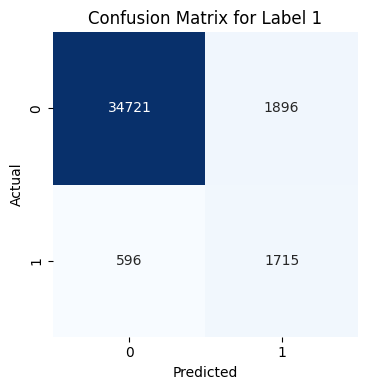

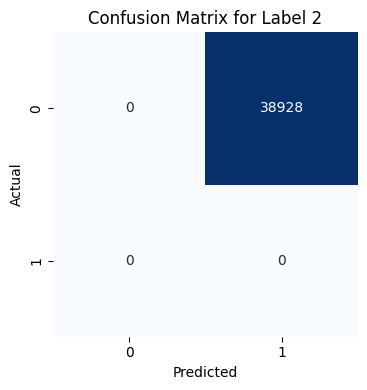

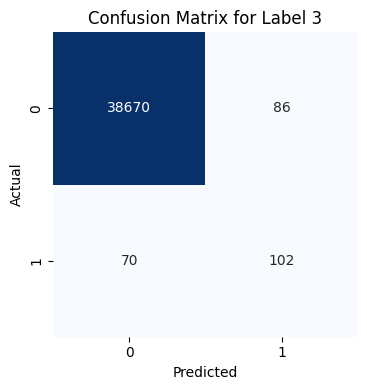

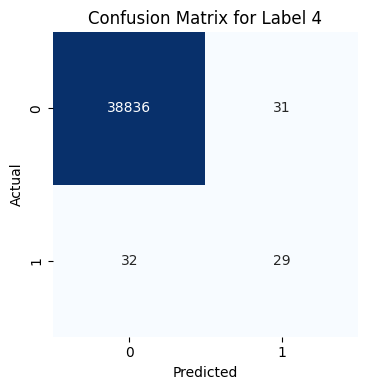

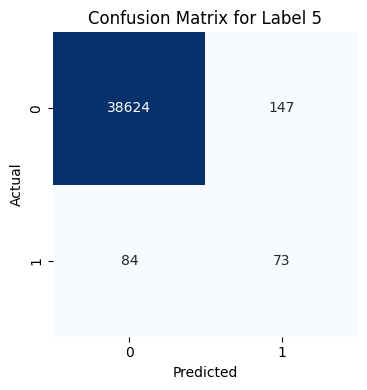

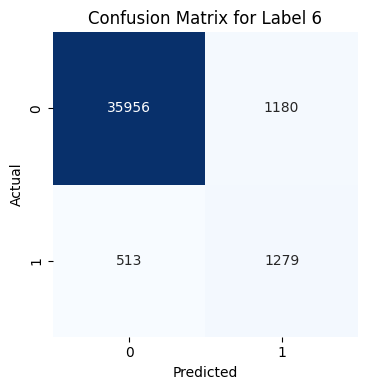

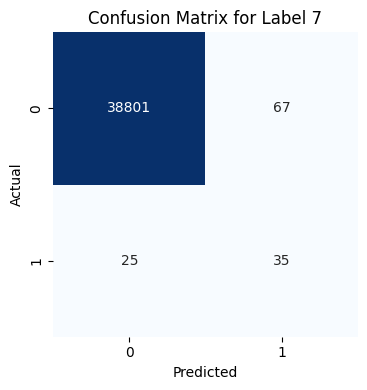

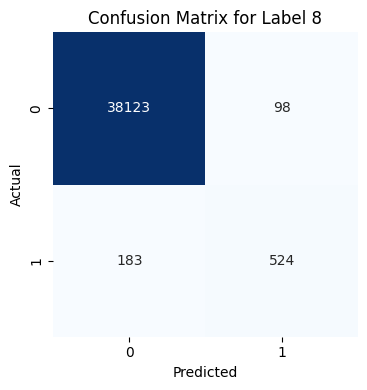

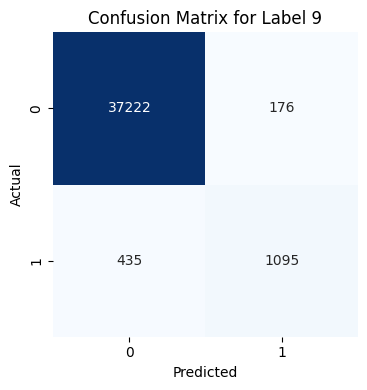

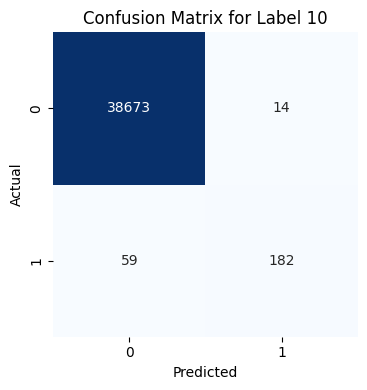

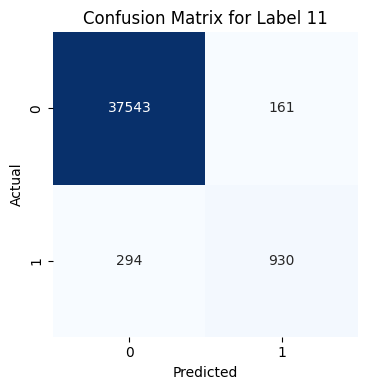

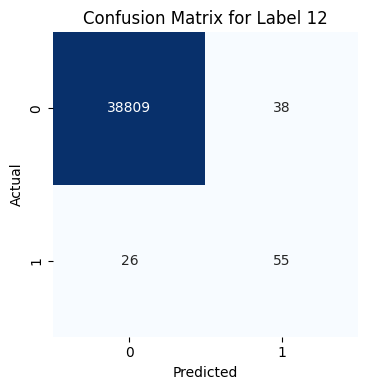

In [65]:
def plot_confusion_matrices(true_labels, predictions, num_labels=12):
    # Loop over each label and create a confusion matrix
    for i in range(num_labels):
        # Compute confusion matrix for label i
        cm = confusion_matrix(true_labels[:, i], predictions[:, i])

        # Plot confusion matrix as a heatmap
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
        plt.title(f"Confusion Matrix for Label {i + 1}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()

        # Show the plot
        plt.show()

# Call the function to plot confusion matrices for all 12 labels
plot_confusion_matrices(true_labels, binary_predictions)